# 🧠 Brain Tumor MRI Classification Using Deep Learning

## 📘 Introduction

Brain tumors are abnormal growths of tissue in the brain that can be either benign (non-cancerous) or malignant (cancerous). Due to the rigidity of the skull, any abnormal mass can lead to increased intracranial pressure, potentially resulting in brain damage or death. Therefore, **early detection and accurate classification of brain tumors** are critical for improving treatment outcomes and saving lives.

This project aims to leverage **Convolutional Neural Networks (CNNs)** to classify brain MRI scans into four categories:

- **Glioma**
- **Meningioma**
- **Pituitary tumor**
- **No tumor**

By applying deep learning techniques to this medical imaging problem, we contribute to the growing field of AI-assisted diagnosis, providing scalable and accurate diagnostic support to healthcare professionals.

## 🧪 Objective

- Perform **image classification** on brain MRI scans using CNNs
- Accurately distinguish between tumor types and healthy cases
- Explore data preprocessing techniques to improve model accuracy
- Lay the groundwork for future expansion into segmentation or malignancy grading tasks

## 📂 About the Dataset

This project uses a publicly available brain MRI dataset that combines images from the following sources:

- **Figshare**
- **SARTAJ**
- **Br35H**

The dataset consists of **7023 brain MRI images** classified into four categories: `glioma`, `meningioma`, `pituitary`, and `no tumor`. The image sizes vary and require preprocessing and resizing to standard dimensions for CNN input.

> ⚠️ *Note from the dataset author: The glioma class from the SARTAJ dataset was found to be misclassified. These were removed and replaced with correctly labeled images from the Figshare dataset.*

## 🙏 Dataset Credits

Dataset provided by [Masoud Nickparvar](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset) on Kaggle.  
If you find this dataset helpful, consider upvoting the original [Kaggle page](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset).

---

*This notebook is part of a research-inspired project to explore the application of CNNs in brain tumor detection using MRI data.*


In [3]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


## 📁 2. Loading and Structuring the Dataset

In this section, we programmatically scan through the dataset directory structure and build a DataFrame that contains the full file paths of all MRI images along with their corresponding set (`Training` or `Testing`) and class labels.

The dataset is organized as follows:

- `archive/`
  - `Training/`
    - `glioma/`
    - `meningioma/`
    - `notumor/`
    - `pituitary/`
  - `Testing/`
    - `glioma/`
    - `meningioma/`
    - `notumor/`
    - `pituitary/`

To prepare the data for analysis and modeling, we:
- Loop through both the `Training` and `Testing` folders.
- Extract the full file paths of images with valid extensions (`.jpg`, `.png`, `.jpeg`).
- Normalize the class labels by converting them to lowercase.
- Store everything in a structured DataFrame with the following columns:
  - `filepaths`: full path to the image file
  - `set`: either `"Training"` or `"Testing"`
  - `class`: one of `"glioma"`, `"meningioma"`, `"notumor"`, or `"pituitary"`

We'll use this DataFrame to perform EDA, visualization, and feed the images into our CNN model later on.


In [4]:
import tensorflow as tf
import torch
print("GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

tf.config.list_physical_devices('GPU')


GPU Available: True
GPU Name: Tesla T4


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
import os
import pandas as pd

# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Set the base path to your dataset inside Drive
# Adjust the path below to your actual folder location in Google Drive
base_dir = '/content/drive/My Drive/colab-data/archive'

filepaths = []
sets = []
classes = []

# Step 3: Loop through Training and Testing directories
for split in ['Training', 'Testing']:
    split_path = os.path.join(base_dir, split)

    for class_folder in os.listdir(split_path):
        class_path = os.path.join(split_path, class_folder)

        if not os.path.isdir(class_path):
            continue

        for img_file in os.listdir(class_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                full_path = os.path.join(class_path, img_file)
                filepaths.append(full_path)
                sets.append(split)
                classes.append(class_folder.lower().strip())

# Step 4: Create DataFrame
df = pd.DataFrame({
    'filepaths': filepaths,
    'set': sets,
    'class': classes
})

# Step 5: Preview
print(df.head())


Mounted at /content/drive
                                           filepaths       set    class
0  /content/drive/My Drive/colab-data/archive/Tra...  Training  notumor
1  /content/drive/My Drive/colab-data/archive/Tra...  Training  notumor
2  /content/drive/My Drive/colab-data/archive/Tra...  Training  notumor
3  /content/drive/My Drive/colab-data/archive/Tra...  Training  notumor
4  /content/drive/My Drive/colab-data/archive/Tra...  Training  notumor


In [6]:
# Check number of samples per set
print("Samples per set:")
print(df['set'].value_counts(), "\n")

# Check number of samples per class
print("Samples per class:")
print(df['class'].value_counts(), "\n")

# Check number of samples per class per set
print("Samples per class per set:")
print(df.groupby(['set', 'class']).size())


Samples per set:
set
Training    3289
Testing     1331
Name: count, dtype: int64 

Samples per class:
class
meningioma    1645
glioma        1621
notumor       1034
pituitary      320
Name: count, dtype: int64 

Samples per class per set:
set       class     
Testing   glioma         300
          meningioma     306
          notumor        405
          pituitary      320
Training  glioma        1321
          meningioma    1339
          notumor        629
dtype: int64


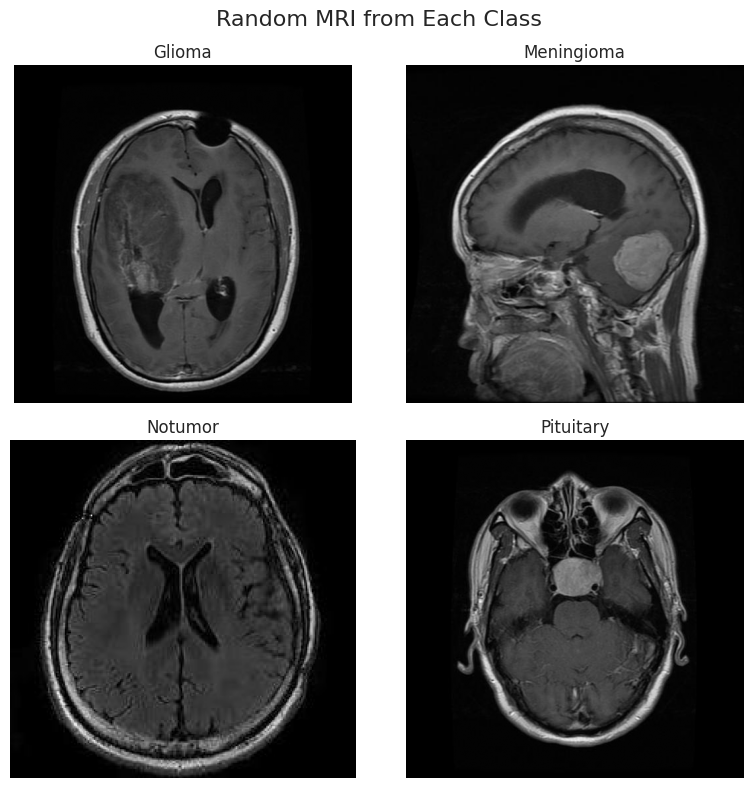

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import random

# Sample one random image per class
sample_df = df.groupby('class').apply(lambda x: x.sample(1)).reset_index(drop=True)

# Plot images in a 2x2 grid
plt.figure(figsize=(8, 8))

for i, row in sample_df.iterrows():
    img = Image.open(row['filepaths'])
    plt.subplot(2, 2, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(row['class'].capitalize())
    plt.axis('off')

plt.suptitle("Random MRI from Each Class", fontsize=16)
plt.tight_layout()
plt.show()


In [10]:
# Filter for training set
train_df = df[df['set'] == 'Training']

# Count class instances
class_counts = train_df['class'].value_counts()

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x='class', order=class_counts.index)
plt.title("Image Count per Class in Training Set")
plt.ylabel("Number of Images")
plt.xlabel("Tumor Class")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


fold
3    658
1    658
0    658
2    658
4    657
Name: count, dtype: int64
fold  class     
0     glioma        264
      meningioma    268
      notumor       126
1     glioma        264
      meningioma    268
      notumor       126
2     glioma        264
      meningioma    268
      notumor       126
3     glioma        264
      meningioma    268
      notumor       126
4     glioma        265
      meningioma    267
      notumor       125
dtype: int64


In [11]:
#TRAIN IMAGES
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x='class', order=class_counts.index)
plt.title("Image Count per Class in Training Set")
plt.ylabel("Number of Images")
plt.xlabel("Tumor Class")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


NameError: name 'class_counts' is not defined

<Figure size 600x400 with 0 Axes>

In [ ]:
#TEST IMAGES
plt.figure(figsize=(6, 4))
sns.countplot(data=test_df, x='class', order=test_class_counts.index)
plt.title("Image Count per Class in Testing Set")
plt.ylabel("Number of Images")
plt.xlabel("Tumor Class")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


## 🔁 2.2 Cross-Validation Setup (5-Fold Stratified)

To ensure a robust evaluation of our model and avoid relying on a single static validation set, we use **5-fold stratified cross-validation**.

### Why Stratified K-Fold?
- **StratifiedKFold** ensures that **each fold maintains the original class proportions**, so no class is under- or over-represented during training or validation.

### How it Works:
1. We extract only the samples from the `Training` set.
2. We apply `StratifiedKFold` to split the dataset into 5 folds.
3. For each sample, we assign a `fold` number from 0 to 4, indicating which validation fold it belongs to.
4. In each round of training, we can:
   - Use **4 folds for training**
   - Use **1 fold for validation**

This results in **5 different training-validation splits**, and every sample is used as validation exactly once.

### Code Summary:
- `train_df['fold']` column stores the fold assignments.
- Class distribution is checked per fold to ensure stratification.

This approach improves generalization and gives a more reliable estimate of the model’s performance before evaluating on the final test set.


In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Get only the training data
train_df = df[df['set'] == 'Training'].copy().reset_index(drop=True)

# Set up StratifiedKFold (5 splits)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Add a column to store fold assignment
train_df['fold'] = -1

# Assign fold numbers
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['class'])):
    train_df.loc[val_idx, 'fold'] = fold

# Verify distribution across folds
print(train_df['fold'].value_counts())
print(train_df.groupby(['fold', 'class']).size())


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# General settings
batch_size = 32
img_size = (299, 299)

# Define your augmentation and preprocessing generators
train_gen_config = ImageDataGenerator(
    rescale=1/255,
    brightness_range=(0.8, 1.2)
)

valid_gen_config = ImageDataGenerator(
    rescale=1/255
)

def get_fold_generators(fold, df, image_size=(299, 299), batch_size=32):
    """
    Returns training and validation generators for a given fold.

    Parameters:
    - fold: int (0 to 4)
    - df: DataFrame with 'filepaths', 'class', and 'fold' columns
    """
    # Split data
    train_df = df[df['fold'] != fold].copy()
    valid_df = df[df['fold'] == fold].copy()

    # Define generators
    train_gen = train_gen_config.flow_from_dataframe(
        dataframe=train_df,
        x_col='filepaths',
        y_col='class',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical'  # change to 'sparse' if using sparse_categorical_crossentropy
    )

    valid_gen = valid_gen_config.flow_from_dataframe(
        dataframe=valid_df,
        x_col='filepaths',
        y_col='class',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_gen, valid_gen






In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get generators for a specific fold (e.g., fold 0)
train_gen, valid_gen = get_fold_generators(fold=0, df=train_df)

# Get class label mapping
class_dict = train_gen.class_indices
classes = list(class_dict.keys())

# Get one batch of images and labels from the validation set
images, labels = next(valid_gen)

# Plot a 4x4 grid of images (adjust to match batch size if needed)
plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images[:16], labels[:16])):  # only show 16
    plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import Xception
from tensorflow.keras.metrics import Precision, Recall

def build_model(input_shape=(299, 299, 3), num_classes=4):
    base_model = Xception(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling='max'
    )

    # Optionally freeze the base model for initial training
    # for layer in base_model.layers:
    #     layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dropout(rate=0.3),
        Dense(128, activation='relu'),
        Dropout(rate=0.25),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adamax(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision(), Recall()]
    )

    return model


In [9]:
for fold in range(5):
    print(f"\n🟦 Training fold {fold + 1}/5")

    # Load generators
    train_gen, valid_gen = get_fold_generators(fold, train_df)

    # Build fresh model for this fold
    model = build_model()

    # Train
    history = model.fit(
        train_gen,
        validation_data=valid_gen,
        epochs=10,  # adjust as needed
        verbose=1
    )



🟦 Training fold 1/5


NameError: name 'get_fold_generators' is not defined